# Introduction to Convolutional Neural Networks

Convolutional Neural Networks (CNN) are one of the key components in the success of Deep Learning and the new Artificial Intelligence revolution. They are specially advantageous in tasks such as object detection, scene understanding and, recently, natural language processing. In this jupyter notebook I will explain what is a convolution and how to train a CNN with the character recognition dataset MNIST.


In [3]:
# Load all needed libraries
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

import sys
import cv2
import time
import torch
import numpy as np
from matplotlib import pyplot as plt
from sklearn.datasets import fetch_openml

print("OS: ", sys.platform)
print("Python: ", sys.version)
print("Numpy: ", np.__version__)
print("PyTorch: ", torch.__version__)

%matplotlib inline


OS:  linux
Python:  3.11.9 (main, Apr 19 2024, 16:48:06) [GCC 11.2.0]
Numpy:  1.26.4
PyTorch:  2.3.1+cu121


## Convolution

CNN are the key resource in deep learning. They are based on a mathematical operation called convolution. A convolution is just a multiplication of an input image (which is a matrix) times a kernel (which is another matrix).

In opencv there is a function called filter2D that allows to generate convolutions. 

In [2]:
def plot_image(image, image2=None):
    # Show one image
    plt.subplot(121)
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
    else:
        plt.imshow(image, cmap=plt.get_cmap("gray"))
    plt.axis("off")
    plt.xticks([]), plt.yticks([])
    if image2 is not None:
        # Show two images
        plt.subplot(122)
        if len(image2.shape) == 3:
            image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)
            plt.imshow(image2)
        else:
            plt.imshow(image2, cmap=plt.get_cmap("gray"))
        plt.axis("off")
        plt.xticks([]), plt.yticks([])
    plt.show()

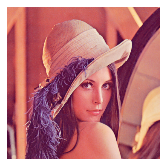

In [3]:
im = cv2.imread("Lenna.png")
plot_image(im)

In [4]:
## Sharpening filter
sharpen = np.array(([0, -1, 0], [-1, 5, -1], [0, -1, 0]), dtype="int")
# Laplacian kernel used to detect edges
laplacian = np.array(([0, 1, 0], [1, -4, 1], [0, 1, 0]), dtype="int")
# Sobel x-axis kernel
sobelX = np.array(([-1, 0, 1], [-2, 0, 2], [-1, 0, 1]), dtype="int")
# Sobel y-axis kernel
sobelY = np.array(([-1, -2, -1], [0, 0, 0], [1, 2, 1]), dtype="int")

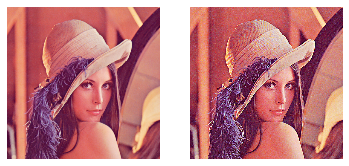

In [5]:
dst = cv2.filter2D(im, -1, sharpen)
plot_image(im, dst)

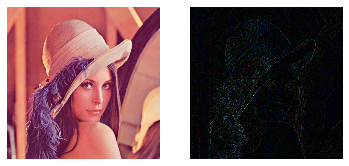

In [6]:
dst = cv2.filter2D(im, -1, laplacian)
plot_image(im, dst)

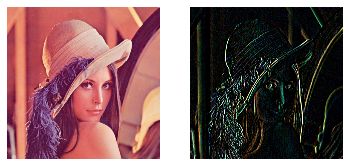

In [7]:
dst = cv2.filter2D(im, -1, sobelX)
plot_image(im, dst)

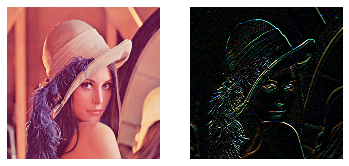

In [8]:
dst = cv2.filter2D(im, -1, sobelY)
plot_image(im, dst)

## Character recognition with MNIST dataset

We are going to use MNIST dataset and Lenet CNN architecture to showcase a deep learning task consisting in recognizing handwritting characters. 

[MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains a training set of 60,000 examples, and a test set of 10,000 examples of hand writting characters.

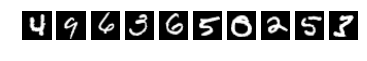

In [9]:
mnist = fetch_mldata("MNIST original")
np.random.seed(1234)  # set seed for deterministic ordering
p = np.random.permutation(mnist.data.shape[0])
X = mnist.data[p]
Y = mnist.target[p]

for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(X[i].reshape((28, 28)), cmap="Greys_r")
    plt.axis("off")
plt.show()

X = X.astype(np.float32) / 255
X_train = X[:60000].reshape((-1, 1, 28, 28))
X_test = X[60000:].reshape((-1, 1, 28, 28))
Y_train = Y[:60000]
Y_test = Y[60000:]

batch_size = 100
train_iter = mx.io.NDArrayIter(X_train, Y_train, batch_size=batch_size)
test_iter = mx.io.NDArrayIter(X_test, Y_test, batch_size=batch_size)

## CNN model: Lenet

Lenet architecture was published by [Yann LeCun et al.](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf) in 1998. The LeNet architecture uses convolutions and pooling to increase the performance. For many years, LeNet was the most accurate algorithm for character recognition and supposed a great advance in deep neural networks, long before the appearance of GPUs and CUDA.

As it can be seen in the following code Lenet has 4 groups of hidden layers, two convolutions and two fully connected layers. Each convolution is followed by an activation and a pooling. 

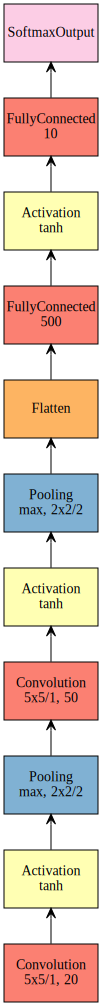

In [10]:
# Network symbolic representation
data = mx.symbol.Variable("data")
input_y = mx.sym.Variable("softmax_label")  # placeholder for output

conv1 = mx.symbol.Convolution(data=data, kernel=(5, 5), num_filter=20)
tanh1 = mx.symbol.Activation(data=conv1, act_type="tanh")
pool1 = mx.symbol.Pooling(data=tanh1, pool_type="max", kernel=(2, 2), stride=(2, 2))

conv2 = mx.symbol.Convolution(data=pool1, kernel=(5, 5), num_filter=50)
tanh2 = mx.symbol.Activation(data=conv2, act_type="tanh")
pool2 = mx.symbol.Pooling(data=tanh2, pool_type="max", kernel=(2, 2), stride=(2, 2))

flatten = mx.symbol.Flatten(data=pool2)
fc1 = mx.symbol.FullyConnected(data=flatten, num_hidden=500)
tanh3 = mx.symbol.Activation(data=fc1, act_type="tanh")
fc2 = mx.symbol.FullyConnected(data=tanh3, num_hidden=10)
lenet = mx.symbol.SoftmaxOutput(data=fc2, label=input_y, name="softmax")

# Lenet visualization
mx.viz.plot_network(lenet)

## Training
Once we have the model and the data, let's put it together and train the CNN.

In [11]:
model = mx.model.FeedForward(
    ctx=mx.cpu(),  # Run on CPU (can also use GPU: ctx = mx.gpu(0))
    symbol=lenet,  # Use the network we just defined
    num_epoch=10,  # Train for 10 epochs
    learning_rate=0.1,  # Learning rate
    optimizer="sgd",  # The optimization method is Stochastic Gradient Descent
    momentum=0.9,  # Momentum for SGD with momentum
    wd=0.00001,
)  # Weight decay for regularization

tic = time.time()
model.fit(
    X=train_iter,  # Training data set
    eval_data=test_iter,  # Testing data set. MXNet computes scores on test set every epoch
    eval_metric=[
        "accuracy"
    ],  # Metric for evaluation: accuracy. Other metrics can be defined
    batch_end_callback=mx.callback.Speedometer(batch_size, 200),
)  # Logging module to print out progress
print("Finished training in %.0f seconds" % (time.time() - tic))

INFO:root:Start training with [cpu(0)]
INFO:root:Epoch[0] Batch [200]	Speed: 165.39 samples/sec	Train-accuracy=0.352100
INFO:root:Epoch[0] Batch [400]	Speed: 156.33 samples/sec	Train-accuracy=0.946650
INFO:root:Epoch[0] Batch [600]	Speed: 154.34 samples/sec	Train-accuracy=0.966650
INFO:root:Epoch[0] Resetting Data Iterator
INFO:root:Epoch[0] Time cost=379.003
INFO:root:Epoch[0] Validation-accuracy=0.967100
INFO:root:Epoch[1] Batch [200]	Speed: 154.41 samples/sec	Train-accuracy=0.971350
INFO:root:Epoch[1] Batch [400]	Speed: 152.97 samples/sec	Train-accuracy=0.980250
INFO:root:Epoch[1] Batch [600]	Speed: 153.50 samples/sec	Train-accuracy=0.982500
INFO:root:Epoch[1] Resetting Data Iterator
INFO:root:Epoch[1] Time cost=391.189
INFO:root:Epoch[1] Validation-accuracy=0.980700
INFO:root:Epoch[2] Batch [200]	Speed: 154.40 samples/sec	Train-accuracy=0.981900
INFO:root:Epoch[2] Batch [400]	Speed: 153.13 samples/sec	Train-accuracy=0.985750
INFO:root:Epoch[2] Batch [600]	Speed: 153.02 samples/sec	

Finished training in 4191 seconds
